#Classification Project - Image Classification of Nature Scenes

- This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }


- The Train, Test and Prediction data is separated in each zip files
- There are around 14k images in Train, 3k in Test and 7k in Prediction.
- This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.
- Link to Dataset : https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [ ]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from google.colab import files
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing import image


In [ ]:
# Step 1: Setup and download the dataset
# Install Kaggle library
!pip install kaggle

# Upload your kaggle.json file (API Key)
files.upload()  # Choose the kaggle.json file

# Ensure kaggle.json is in the proper location and has the correct permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip -d dataset

Saving kaggle.json to kaggle.json
 96% 332M/346M [00:02<00:00, 178MB/s]
100% 346M/346M [00:02<00:00, 152MB/s]


In [ ]:


# Define the path to the dataset directories
train_dataset_path = '/content/dataset/seg_train/seg_train'
test_dataset_path = '/content/dataset/seg_test/seg_test'
pred_dataset_path = '/content/dataset/seg_pred/seg_pred'

In [ ]:
# Get class names from the train dataset
class_names = sorted(os.listdir(train_dataset_path))
n_classes = len(class_names)
print(f"Number of Classes : {n_classes}\nClass names : {class_names}")
# Count the number of images in each class
class_counts = [len(os.listdir(os.path.join(train_dataset_path, class_name))) for class_name in class_names]

Number of Classes : 6
Class names : ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


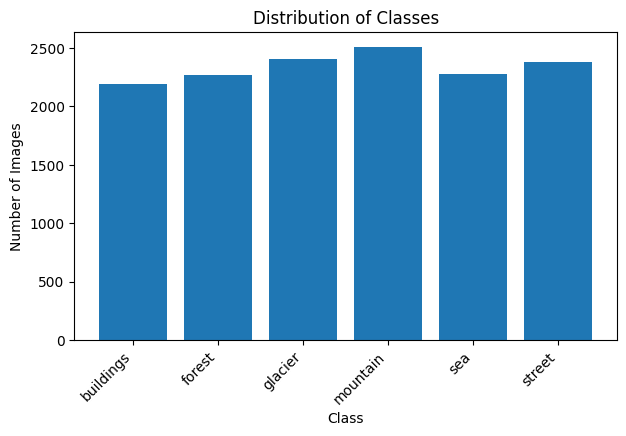

In [ ]:
import matplotlib.pyplot as plt
# Plot the distribution
plt.figure(figsize=(7, 4))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
# Batch size
batch_size = 128

In [ ]:
# Create the ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:

# Create the ImageDataGenerators for training and testing sets, specifying classes
train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Sample images from the training set:


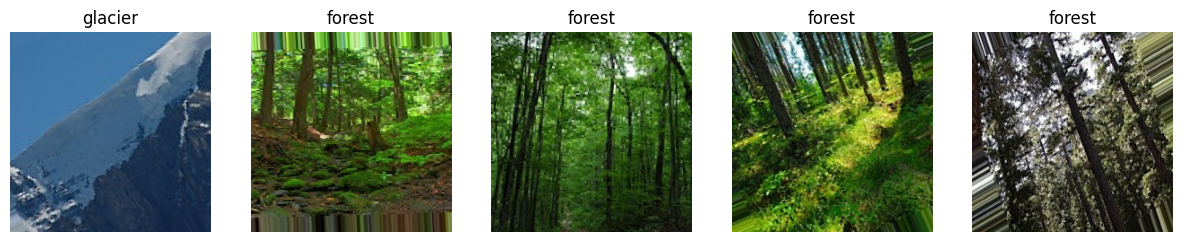

---------------------------------------------------------------------------------------------------------------------------------------------
Sample images from the testing set:


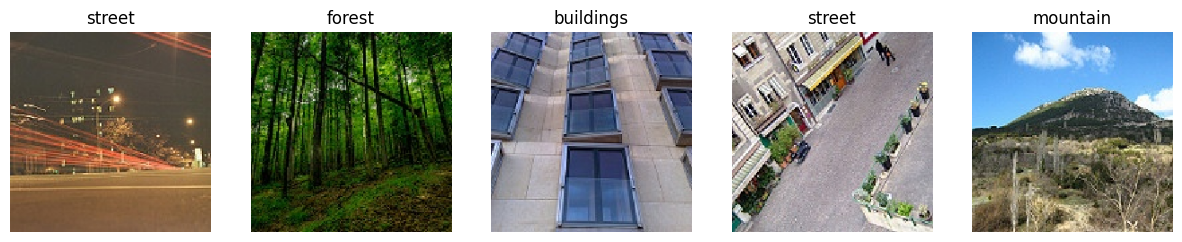

In [ ]:
# Define a function to display images with their labels using generators
def visualize_image(generator, num_samples=5):
    # Get a batch of images
    images, labels = next(generator)
    # Get class labels from the generator
    class_names = list(generator.class_indices.keys())
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        # Display the first num_samples images
        if i < num_samples:
            ax.imshow(images[i])
            # Find the class label from one-hot encoded vectors
            label = class_names[np.argmax(labels[i])]
            ax.set_title(label)
            ax.axis('off')
    plt.show()

# Display some sample images with their labels
print("Sample images from the training set:")
visualize_image(train_generator)
print("---------------------------------------------------------------------------------------------------------------------------------------------")
print("Sample images from the testing set:")
visualize_image(test_generator)

In [ ]:
# Get a sample batch from the train_generator
sample_batch = next(train_generator)
input_shape = sample_batch[0][0].shape
input_shape

(224, 224, 3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Define the model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Compile the model
model.compile(loss='CategoricalCrossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

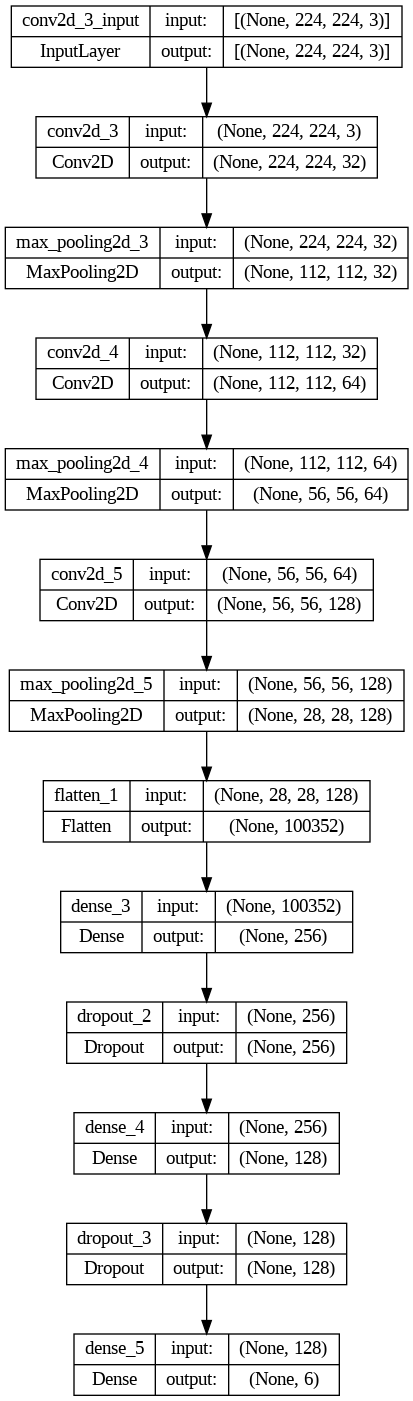

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'model_image_classification_shapes.png', show_shapes=True)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Use the generator's samples property
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,  # Use the generator's samples property
    callbacks=[early_stopping]
)

Epoch 1/20
109/109 [==============================] - 198s 2s/step - loss: 1.4337 - accuracy: 0.4326 - val_loss: 1.1393 - val_accuracy: 0.5499
Epoch 2/20
109/109 [==============================] - 180s 2s/step - loss: 1.0966 - accuracy: 0.5682 - val_loss: 0.9069 - val_accuracy: 0.6416
Epoch 3/20
109/109 [==============================] - 178s 2s/step - loss: 0.9793 - accuracy: 0.6266 - val_loss: 0.7845 - val_accuracy: 0.7092
Epoch 4/20
109/109 [==============================] - 179s 2s/step - loss: 0.8799 - accuracy: 0.6745 - val_loss: 0.7075 - val_accuracy: 0.7429
Epoch 5/20
109/109 [==============================] - 179s 2s/step - loss: 0.8125 - accuracy: 0.7130 - val_loss: 0.6496 - val_accuracy: 0.7643
Epoch 6/20
109/109 [==============================] - 181s 2s/step - loss: 0.7748 - accuracy: 0.7226 - val_loss: 0.6026 - val_accuracy: 0.7826
Epoch 7/20
109/109 [==============================] - 177s 2s/step - loss: 0.7217 - accuracy: 0.7467 - val_loss: 0.5715 - val_accuracy: 0.8050

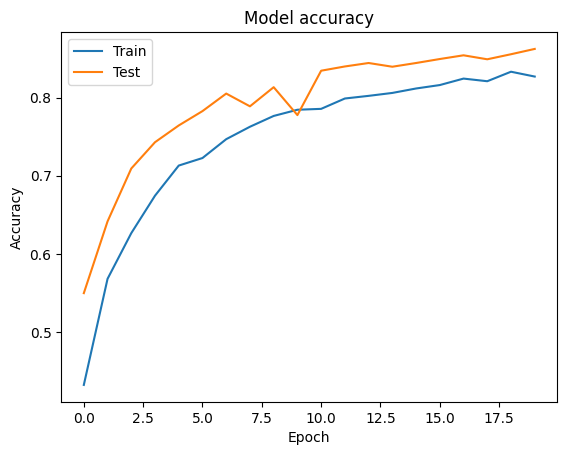

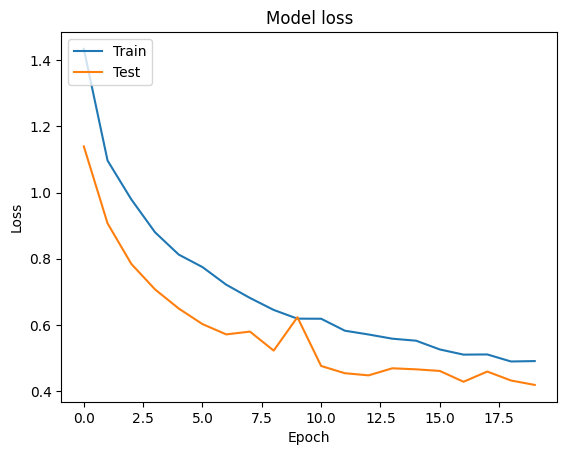

In [ ]:
# Step 6: Visualize Training Results
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_training_history(history)

In [ ]:
# Save the model
model.save('my_model.h5')  # Creates a HDF5 file 'my_model.h5'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Later, to load the model
from tensorflow.keras.models import load_model
saved_model = load_model('my_model.h5')

1/1 [==============================] - 0s 34ms/step


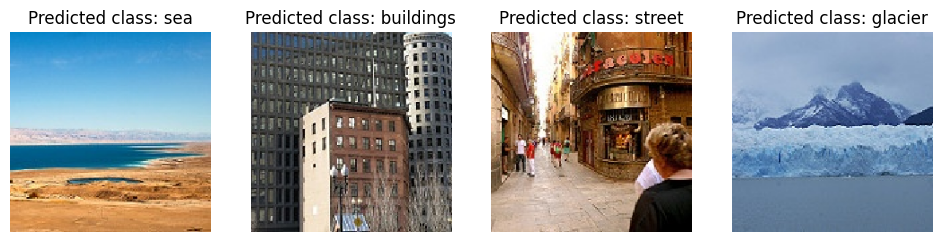

In [ ]:
def predict_image(image_path, model, class_names):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Rescale the image
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions)
    predicted_class = class_names[predicted_class_idx]
    return predicted_class, img

# Define class names
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Predict on all images in the seg_pred directory and display them
pred_images = os.listdir(pred_dataset_path)
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
for i, img_name in enumerate(pred_images[:4]):
    img_path = os.path.join(pred_dataset_path, img_name)
    prediction, img = predict_image(img_path, saved_model, class_names)
    ax = fig.add_subplot(rows, columns, i+1)
    ax.imshow(img)
    ax.set_title(f"Predicted class: {prediction}")
    ax.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
# Load the pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification
model_trained = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])
# Compile the model
model_trained.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
model_trained.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Use the generator's samples property
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,  # Use the generator's samples property
    callbacks=[early_stopping]
)


Epoch 1/10
109/109 [==============================] - 225s 2s/step - loss: 2.9330 - accuracy: 0.3591 - val_loss: 1.1917 - val_accuracy: 0.5017
Epoch 2/10
109/109 [==============================] - 185s 2s/step - loss: 1.2298 - accuracy: 0.5010 - val_loss: 1.0415 - val_accuracy: 0.5921
Epoch 3/10
109/109 [==============================] - 185s 2s/step - loss: 1.1495 - accuracy: 0.5358 - val_loss: 1.0442 - val_accuracy: 0.5554
Epoch 4/10
109/109 [==============================] - 184s 2s/step - loss: 1.0841 - accuracy: 0.5614 - val_loss: 0.9528 - val_accuracy: 0.6067
Epoch 5/10
109/109 [==============================] - 183s 2s/step - loss: 1.0416 - accuracy: 0.5885 - val_loss: 0.9806 - val_accuracy: 0.5866
Epoch 6/10
109/109 [==============================] - 186s 2s/step - loss: 1.0208 - accuracy: 0.5897 - val_loss: 0.8990 - val_accuracy: 0.6478
Epoch 7/10
109/109 [==============================] - 186s 2s/step - loss: 0.9712 - accuracy: 0.6151 - val_loss: 0.8552 - val_accuracy: 0.6702